In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [2]:
from google.colab import files
uploaded = files.upload()

Saving emails.csv to emails.csv


In [3]:
pf = pd.read_csv('emails.csv')
pf.head(10)

,text,label
0,Re: svn commit: r619753 - in /spamassassin/tru...,1
1,[Bug 5780] URI processing turns uuencoded stri...,1
2,RE: Trial IRC Certificate Application \nPlelim...,1
3,"Re: [opensuse] Why can't I use ""shutdown now"" ...",0
4,[Spambayes-checkins] spambayes/spambayes stora...,1
5,Re: [opensuse] OpenSuse 11 Benji Weber wrote:\...,1
6,[Bookscanada] Was a book written about this - ...,0
7,[Bug 5780] [review] URI processing turns uuenc...,1
8,Tell your friend how to quit smoking. \n\n\n\...,0
9,[Crm114-announce] crm114 filters all mails to ...,1


In [4]:
pf.shape

(6360, 2)

In [5]:
# NO PREPROCESSING as phake emails should include: URLs, special characters, punctuation,numbers, stopwords, capital letters,
# stemming or lemmatization, HTML tags, incorrect spelling

# INSTEAD, remove null, and perform lowercasing

pf.dropna(inplace=True)
pf['text'] = pf['text'].str.lower()

In [6]:
#recheck dataset quantity
pf.shape

(6360, 2)

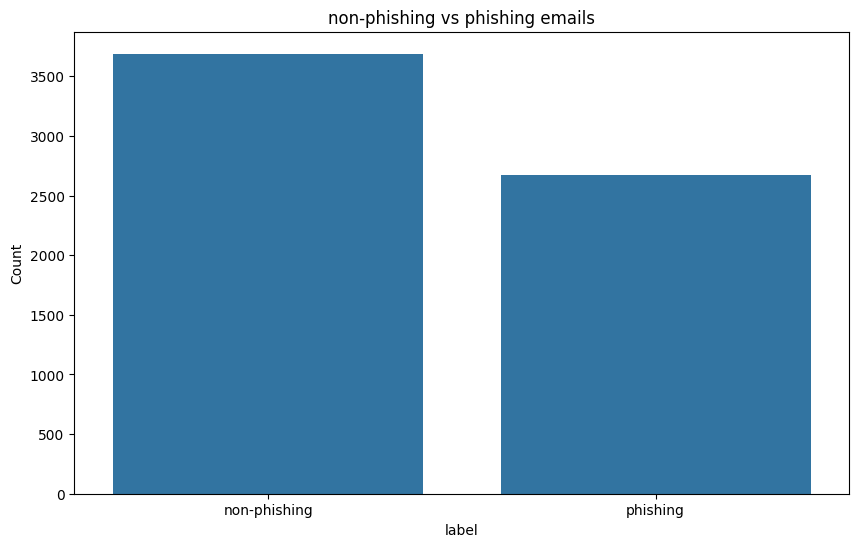

In [7]:
plt.figure(figsize=(10,6))
sns.countplot(data=pf,x='label')#the orrcurrences number of each np.unique value in the column
plt.title('non-phishing vs phishing emails')
plt.xticks(ticks=[0,1],labels=['non-phishing','phishing'])
plt.ylabel('Count')
plt.show()

In [8]:
print(pf["label"].value_counts())#optional

label
0    3689
1    2671
Name: count, dtype: int64


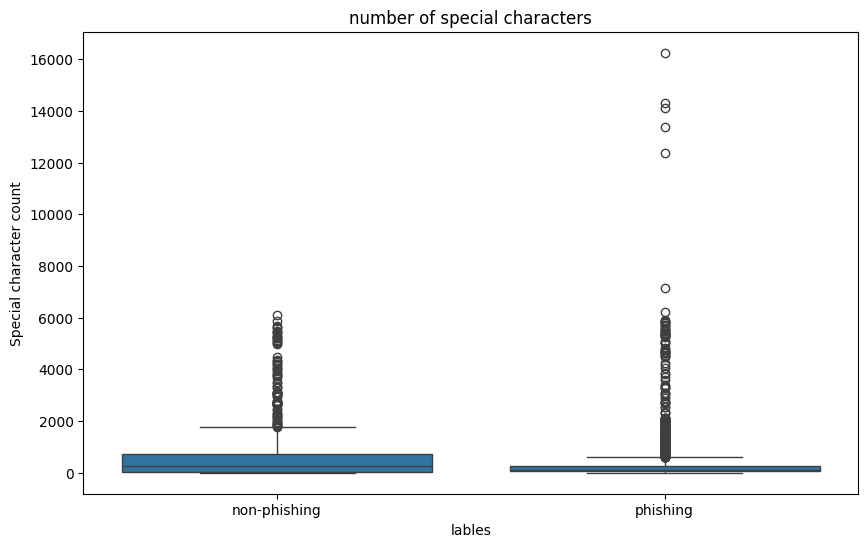

In [9]:
# SPECIAL CHARACTER COUNTER
pf['special_characters'] = pf['text'].apply(lambda x: sum(not x.isalnum() and not x.isspace() for x in x)) #FOR EACH ROW IN "text"->CHECK CHARACTER->TRUE IF NEITHER LETTER NOR DEGIT NOR SPACE
plt.figure(figsize=(10,6))#create a new blank figure that is 10inch (width) and 6inch(height)
sns.boxplot(x='label', y='special_characters', data=pf)# tell Seaborn to use data from pf
plt.xticks([0,1], ['non-phishing', 'phishing'])
plt.xlabel('lables')
plt.ylabel('Special character count')
plt.title('number of special characters')
plt.show()


In [10]:
# download stopwords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

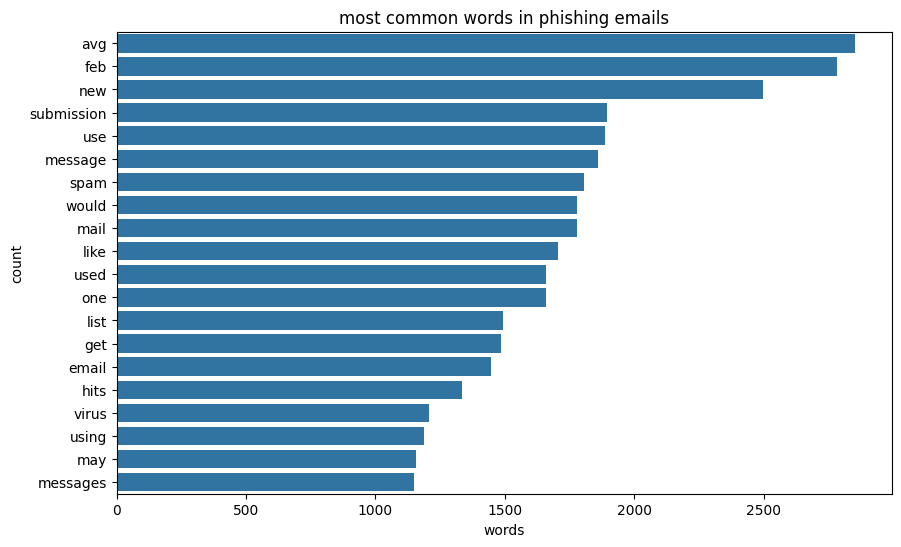

In [ ]:
from collections import Counter
# joining text from phishing and legitimate emails -> convert to lowercasw ->split into words
phishing_text= ' '.join(pf[pf['label']==1]['text'].str.lower()).split()
legitimate_text= ' '.join(pf[pf['label']==0]['text'].str.lower()).split()

# stopwords filtering conditon
stop_words = set(stopwords.words("english"))
cleaned_phishing_text = [word for word in phishing_text if word.isalpha() and word not in stop_words]# keep only alphabet words
cleaned_legitimate_text = [word for word in legitimate_text if word.isalpha() and word not in stop_words]# keep only alphabet words

# list common words
common_phishing_words= Counter(cleaned_phishing_text)
common_legitimate_words= Counter(cleaned_legitimate_text)

# convert to sets 
phishing_words = set(common_phishing_words.keys())
legitimate_words = set(common_legitimate_words.keys())

# find words that appear in phishing but not legitimate emails
only_phishing = phishing_words - legitimate_words

# count the frequency of unique phishing words
only_phishing_count = {word:common_phishing_words[word] for word in only_phishing}

# count the frequency of unique phishing words
top_n = 20
only_phishing_sort = dict(sorted(only_phishing_count.items(), key=lambda item : item[1], reverse=True)[:top_n])

# convert to dataframe for easy plotting
only_phishing_df = pd.DataFrame(list(only_phishing_sort.items()), columns=["word", "common_phishing_words"])

# plotting the bar chart
plt.figure(figsize=(10,6))
sns.barplot(data=only_phishing_df, x="common_phishing_words", y="word")

# add titles and labels
plt.title('keywords unique to phishing emails')
plt.xlabel('count')
plt.ylabel('words')
plt.show()

In [12]:
from sklearn.model_selection import train_test_split

# 70% train + 30% remain (test and valuation)
train_text, remain_text, train_labels, remain_labels = train_test_split(
    pf['text'].tolist(),
    pf['label'].tolist(),
    test_size=0.30,
    random_state=42,
    stratify=pf['label'].tolist() # ONLY FOR LABELED DATASET
)

# 10% valuation, 20% test
val_text, test_text, val_labels, test_labels = train_test_split(
    remain_text,
    remain_labels,
    test_size=2/3,  # 20% of 30%
    random_state=42,
    stratify= remain_labels # ONLY FOR LABELED DATASET
)



In [13]:
!pip install transformers

In [14]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer #can be either roBert or any BERT family members
model_name = "distilbert-base-uncased"
# instantiating DL model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2) #create model object that Trainer needs

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
#BERT only understand numerical input, the process should be raw text -> tokens -> numerical IDs
tokenizer = AutoTokenizer.from_pretrained(model_name) # convert texts into token IDs

#tokenize the datasets (PREPROCESSING)
MAX_LEN = 128

train_text = list(train_text)
train_labels = list(train_labels)
train_encodings = tokenizer(train_text, truncation=True, padding=True, max_length=MAX_LEN)

val_text = list(val_text)
val_labels = list(val_labels)
val_encodings = tokenizer(val_text, truncation=True, padding=True, max_length=MAX_LEN)

test_text = list(test_text)
test_labels = list(test_labels)
test_encodings = tokenizer(test_text, truncation=True, padding=True, max_length = MAX_LEN)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [16]:
# this step is OPTIONAL (FOR BETTER UNDERSTANDING DATA TOKENIZATION)
# turn emails into input_ids and attention_mask
print(train_encodings['input_ids'][0]) # wordpiece token ID (Each number corresponds to a word-piece from the model’s vocabulary)
print(train_encodings['attention_mask'][0]) # tells model which tokens are padding (0) vs real words (1)
# View raw data
print(tokenizer.decode(train_encodings["input_ids"][0]))


[101, 13229, 1012, 4012, 3679, 2327, 2184, 1028, 1009, 1027, 1009, 1027, 1009, 1027, 1009, 1027, 1009, 1027, 1009, 1027, 1009, 1027, 1009, 1027, 1009, 1027, 1009, 1027, 1009, 1027, 1009, 1027, 1009, 1027, 1009, 1027, 1009, 1027, 1009, 1027, 1009, 1027, 1009, 1027, 1009, 1027, 1009, 1027, 1009, 1027, 1009, 1027, 1009, 1027, 1009, 1027, 1009, 1027, 1009, 1027, 1009, 1027, 1009, 1027, 1009, 1027, 1009, 1027, 1028, 1996, 3679, 2327, 2184, 1028, 2013, 13229, 1012, 4012, 1028, 2327, 6876, 1998, 3441, 2004, 1997, 1024, 15476, 1015, 1010, 2263, 1017, 1024, 5388, 7610, 3968, 2102, 1028, 1009, 1027, 1009, 1027, 1009, 1027, 1009, 1027, 1009, 1027, 1009, 1027, 1009, 1027, 1009, 1027, 1009, 1027, 1009, 1027, 1009, 1027, 1009, 1027, 1009, 1027, 1009, 1027, 1009, 1027, 102]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [17]:
#wrap tokenized data into a Dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):#store tokenzied input data (encodings) and labels
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx): #return the input tensors for a specific index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype = torch.long)
        return item
    def __len__(self):#return the total number of samples
        return len(self.labels)

train_dataset = Dataset(train_encodings, train_labels)
val_dataset = Dataset(val_encodings, val_labels)
test_dataset = Dataset(test_encodings, test_labels)


In [18]:
# define evaluation metrics
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    accScore = accuracy_score(labels, preds)

    return {
        'accuracy': accScore, # overall correctness
        'f1': f1,             # Balance between precision & recall
        'precision': precision,## how many were actually phishing, on the of phishing labeled email (low = many false alarms)
        'recall': recall       # Out of all real phishing emails, how many did we catch (low = many phishing emails missed)
    }

In [19]:
#define trainning settings(before training the model)
from transformers import TrainingArguments
trainning_args = TrainingArguments( #define how the model should be trained
    output_dir='./results',          # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=10,  # batch size per device during training
    learning_rate=2e-5,              #define how fast the model learns
    per_device_eval_batch_size=64,   # batch size for evaluation
    save_strategy = "epoch",          # save checkpoint after each epoch
    logging_dir='./logs',            # directory for storing logs
    report_to=["none"],                # turn off W&B while debugging
    eval_strategy="epoch",
    logging_strategy="steps",   # or "epoch"
    logging_steps=50            # ensure some train-loss logs per epoch

)

In [20]:
from transformers import Trainer, DataCollatorWithPadding
#Trainer simplifies teh process of training the model
trainer = Trainer(
    model = model,
    args = trainning_args,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    compute_metrics = compute_metrics,
    tokenizer = tokenizer,
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
)

/tmp/ipython-input-3600518076.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [21]:

trainer.train()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.225700,0.182159,0.940252,0.928030,0.938697,0.917603


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.225700,0.182159,0.940252,0.928030,0.938697,0.917603
2,0.140800,0.192961,0.943396,0.932075,0.939163,0.925094


TrainOutput(global_step=892, training_loss=0.2054669194157348, metrics={'train_runtime': 5768.7212, 'train_samples_per_second': 1.543, 'train_steps_per_second': 0.155, 'total_flos': 294872429408256.0, 'train_loss': 0.2054669194157348, 'epoch': 2.0})

In [22]:
eval_metrics = trainer.evaluate()     # uses val_dataset
print("Validation metrics:", eval_metrics)# shows eval_loss, accuracy, precision, recall, f1 (from compute_metrics)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation metrics: {'eval_loss': 0.19296057522296906, 'eval_accuracy': 0.9433962264150944, 'eval_f1': 0.9320754716981132, 'eval_precision': 0.9391634980988594, 'eval_recall': 0.9250936329588015, 'eval_runtime': 121.1845, 'eval_samples_per_second': 5.248, 'eval_steps_per_second': 0.083, 'epoch': 2.0}


In [23]:
# get test set prediction
pred = trainer.predict(test_dataset)
y_true = pred.label_ids
y_pred = pred.predictions.argmax(-1)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [24]:

# print(confusion_matrix(y_true, y_pred))
# print(classification_report(y_true, y_pred, target_names=["Safe","Phishing"]))

test_pred = trainer.predict(test_dataset, metric_key_prefix="test")
print("Test metrics from Trainer:", test_pred.metrics)

print("\nConfusion matrix:")
print(confusion_matrix(y_true, y_pred, labels=[0,1]))
print("\nClassification report:")
print(classification_report(y_true, y_pred, labels=[0,1], target_names=["Safe","Phishing"], zero_division=0))

print("\nCore metrics:")
print("Accuracy: ", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, zero_division=0))
print("Recall:   ", recall_score(y_true, y_pred, zero_division=0))
print("F1 Score: ", f1_score(y_true, y_pred, zero_division=0))



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Test metrics from Trainer: {'test_loss': 0.21137818694114685, 'test_accuracy': 0.9331761006289309, 'test_f1': 0.9189704480457579, 'test_precision': 0.9359223300970874, 'test_recall': 0.9026217228464419, 'test_runtime': 279.5044, 'test_samples_per_second': 4.551, 'test_steps_per_second': 0.072}

Confusion matrix:
[[705  33]
 [ 52 482]]

Classification report:
              precision    recall  f1-score   support

        Safe       0.93      0.96      0.94       738
    Phishing       0.94      0.90      0.92       534

    accuracy                           0.93      1272
   macro avg       0.93      0.93      0.93      1272
weighted avg       0.93      0.93      0.93      1272


Core metrics:
Accuracy:  0.9331761006289309
Precision: 0.9359223300970874
Recall:    0.9026217228464419
F1 Score:  0.9189704480457579


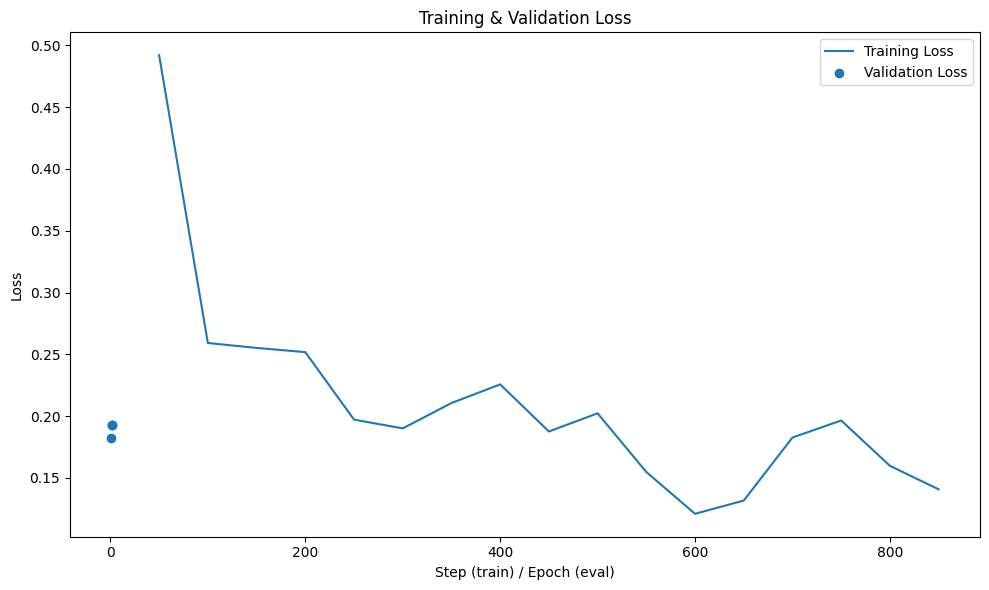

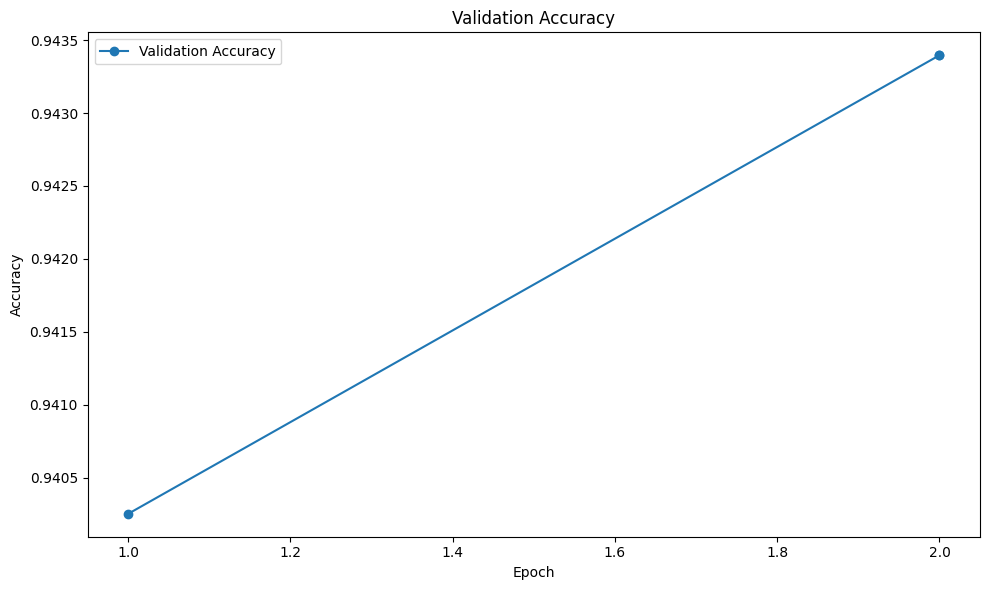

In [25]:
import matplotlib.pyplot as plt
from collections import defaultdict



import matplotlib.pyplot as plt

logs = trainer.state.log_history

# train loss by STEP
train_steps = [e["step"] for e in logs if "loss" in e and "step" in e]
train_loss  = [e["loss"] for e in logs if "loss" in e and "step" in e]

# eval metrics by EPOCH
eval_epochs = [int(round(e["epoch"])) for e in logs if "eval_loss" in e]
val_loss    = [e["eval_loss"] for e in logs if "eval_loss" in e]
val_acc     = [e["eval_accuracy"] for e in logs if "eval_accuracy" in e]

# Loss plot
plt.figure(figsize=(10,6))
plt.plot(train_steps, train_loss, label="Training Loss")
if val_loss:
    plt.scatter(eval_epochs, val_loss, marker="o", label="Validation Loss")
plt.xlabel("Step (train) / Epoch (eval)"); plt.ylabel("Loss")
plt.title("Training & Validation Loss"); plt.legend(); plt.tight_layout(); plt.show()

# Validation accuracy plot
if val_acc:
    plt.figure(figsize=(10,6))
    plt.plot(eval_epochs, val_acc, marker="o", label="Validation Accuracy")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.title("Validation Accuracy"); plt.legend(); plt.tight_layout(); plt.show()




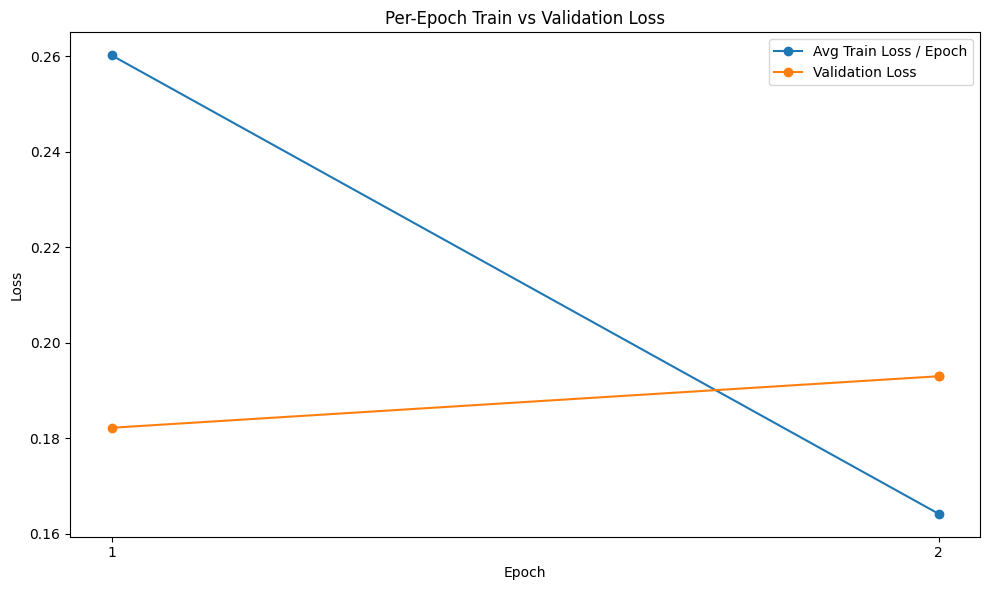

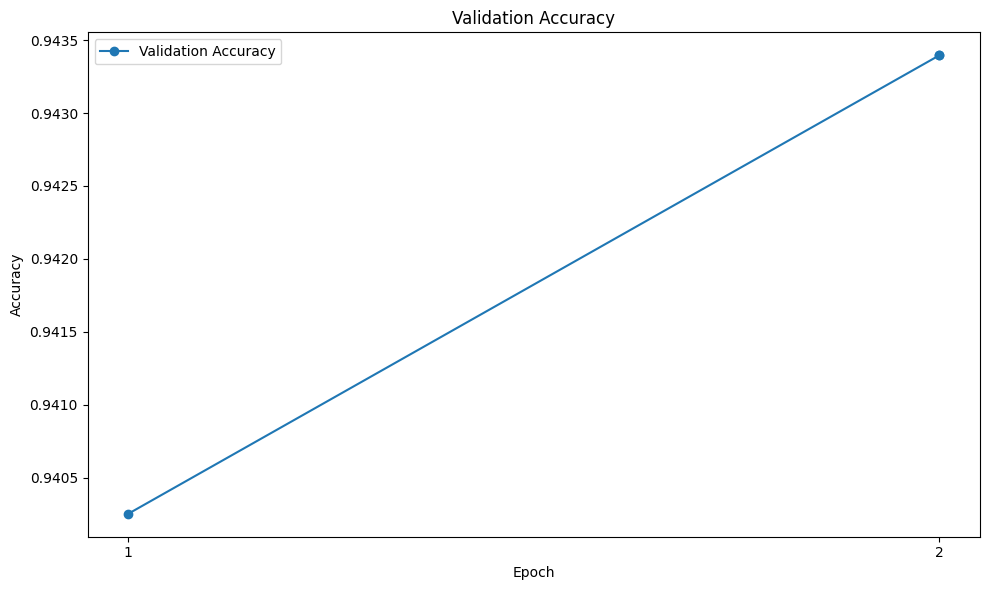

In [26]:
from collections import defaultdict
from math import ceil
import matplotlib.pyplot as plt

logs = trainer.state.log_history

# average training loss per epoch
epoch_sum, epoch_cnt = defaultdict(float), defaultdict(int)
last_ep = 1
for e in logs:
    if "epoch" in e:
        last_ep = max(1, int(ceil(e["epoch"])))
    if "loss" in e:
        epoch_sum[last_ep] += e["loss"]
        epoch_cnt[last_ep] += 1

train_epochs   = sorted(epoch_sum)
avg_train_loss = [epoch_sum[ep]/epoch_cnt[ep] for ep in train_epochs]

# eval (per epoch)
eval_epochs = [int(round(e["epoch"])) for e in logs if "eval_loss" in e]
val_loss    = [e["eval_loss"] for e in logs if "eval_loss" in e]
val_acc     = [e["eval_accuracy"] for e in logs if "eval_accuracy" in e]

# aligned loss plot
plt.figure(figsize=(10,6))
plt.plot(train_epochs, avg_train_loss, marker="o", label="Avg Train Loss / Epoch")
if val_loss:
    plt.plot(eval_epochs, val_loss, marker="o", label="Validation Loss")
plt.xticks(range(1, max([*train_epochs, *eval_epochs], default=1)+1))
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Per-Epoch Train vs Validation Loss")
plt.legend(); plt.tight_layout(); plt.show()

# validation accuracy
if val_acc:
    plt.figure(figsize=(10,6))
    plt.plot(eval_epochs, val_acc, marker="o", label="Validation Accuracy")
    plt.xticks(range(1, max(eval_epochs)+1))
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Validation Accuracy")
    plt.legend(); plt.tight_layout(); plt.show()


In [27]:
args = TrainingArguments(
    output_dir='./results',
    logging_strategy="steps",     # or "epoch" (either is fine)
    logging_steps=50,             # if using "steps"
    eval_strategy="epoch",  # <-- ensures eval_* appears once per epoch
    # compute_metrics=compute_metrics,  # already set on your Trainer
)

In [28]:
print("train_epochs:", train_epochs)
print("avg_train_loss:", avg_train_loss)
print("eval_epochs:", eval_epochs)
print("val_loss:", val_loss)


train_epochs: [1, 2]
avg_train_loss: [0.26022500000000004, 0.16413333333333335]
eval_epochs: [1, 2, 2]
val_loss: [0.182159423828125, 0.19296057522296906, 0.19296057522296906]


In [29]:
#save the final model and tokenize
trainer.save_model('final_model')
tokenizer.save_pretrained('final_model')

('final_model/tokenizer_config.json',
 'final_model/special_tokens_map.json',
 'final_model/vocab.txt',
 'final_model/added_tokens.json',
 'final_model/tokenizer.json')

In [30]:
# test the model
test_encoding = tokenizer(test_text, truncation=True, padding=True)
#convert to PyTorch Dataset
test_dataset = Dataset(test_encoding, test_labels)


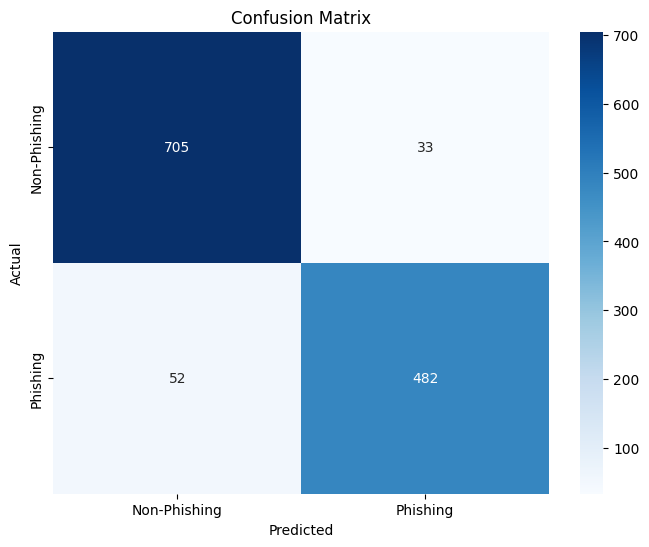

In [33]:
# plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Phishing', 'Phishing'], yticklabels=['Non-Phishing', 'Phishing'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

https://www.youtube.com/watch?v=AT857mWvl0g